# Project: Food Vision Big TM

In [1]:
# Import libraries and checking using GPU
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

# Check if GPU is available
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:   
    print(f"GPU is available: {gpu_available}")
else:
    print("GPU is not available, using CPU instead.")

2025-07-05 23:27:29.812923: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-05 23:27:29.826978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751732849.838479    9075 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751732849.841882    9075 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751732849.851075    9075 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
!nvidia-smi

/bin/bash: /home/dikhang_hcmut/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sat Jul  5 23:27:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   45C    P8              2W /   73W |      74MiB /   6141MiB |      0%      Default |
|             

In Colab, they provide a GPU for free, so we can use it to train our model. But in this project, I decided to use my own GPU to train the model. The GPU is a NVIDIA GeForce RTX 4050.

And I have to mearsure that it's compatible with using mixed precision training...

## Get the helper functions


In [3]:
!mkdir help_funcs && cd help_funcs && wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

/bin/bash: /home/dikhang_hcmut/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mkdir: cannot create directory ‘help_funcs’: File exists


In [4]:
# Import the helper functions
import sys
sys.path.append('help_funcs/')
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data

In [5]:
!pip install tensorflow_datasets

/bin/bash: /home/dikhang_hcmut/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## Import the dataset


In [6]:
import tensorflow_datasets as tfds
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

2025-07-05 23:27:34.403148: W external/local_xla/xla/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".


True


In [7]:
# 
(train_data, test_data), ds_info = tfds.load(
    name="food101",
    split=["train", "validation"],
    shuffle_files=True,
    data_dir="datasets", # where to save the dataset
    with_info=True,
    as_supervised=True # data gets returned as tuple (image, label)
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling datasets/food101/incomplete.XDZVN9_2.0.0/food101-train.tfrecord*...:   0%|          | 0/75750 [00:00…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling datasets/food101/incomplete.XDZVN9_2.0.0/food101-validation.tfrecord*...:   0%|          | 0/25250 […

Dataset food101 downloaded and prepared to datasets/food101/2.0.0. Subsequent calls will reuse this data.


I0000 00:00:1751737250.314551    9075 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
# Features of Food101 TFDS
ds_info.features

# Get the classnames
class_names = ds_info.features['label'].names
print(class_names[:10]) # print first 10 class names

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [12]:
# Output info about our training sample
train_one_sample = train_data.take(1)
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 23
  Class name (str form): churros
        


In [13]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[189, 165, 121],
        [185, 161, 117],
        [181, 157, 113],
        ...,
        [111,  72,  33],
        [103,  64,  25],
        [ 94,  55,  16]],

       [[186, 162, 118],
        [183, 159, 115],
        [180, 156, 112],
        ...,
        [122,  83,  40],
        [113,  74,  31],
        [105,  66,  23]],

       [[180, 156, 112],
        [178, 154, 110],
        [177, 153, 109],
        ...,
        [132,  94,  45],
        [124,  87,  35],
        [120,  83,  31]],

       ...,

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [231, 225, 191],
        [231, 225, 189],
        [231, 226, 188]],

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [230, 224, 190],
        [230, 224, 188],
        [229, 223, 187]],

       [[206, 203, 158],
        [204, 200, 153],
        [203, 195, 146],
        ...,
        [229, 223, 18

In [14]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot the images from TFDS


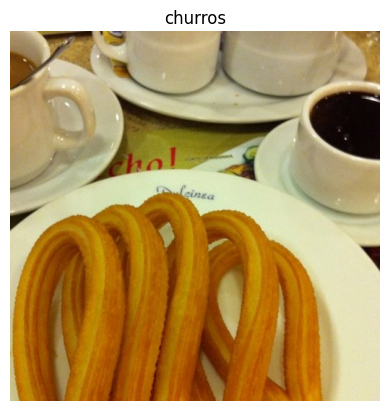

In [15]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

In [16]:

# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [17]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[189 165 121]
  [185 161 117]
  [181 157 113]
  ...
  [111  72  33]
  [103  64  25]
  [ 94  55  16]]

 [[186 162 118]
  [183 159 115]
  [180 156 112]
  ...
  [122  83  40]
  [113  74  31]
  [105  66  23]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[184.91327  160.91327  116.91326 ]
  [180.35715  156.35715  112.35714 ]
  [183.71428  160.71428  118.71429 ]
  ...
  [147.5915   108.66289   69.08129 ]
  [123.576454  84.576454  44.198887]
  [106.44359   67.44359   25.872158]]

 [[174.66837  150.66837  106.668365]
  [175.14285  151.14285  107.14286 ]
  [177.80103  153.22958  112.015305]
  ...
  [155.61722  119.545784  68.443695]
  [145.1989   108.19381   53.423363]
  [134.37747   98.30605   40.73462 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


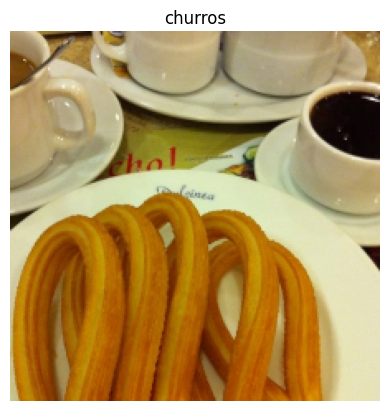

In [18]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);